# IBM HR Analytics - Análise de Atrito de Funcionários
## Pipeline de Dados na Nuvem - MVP

**Objetivo:** Identificar fatores que influenciam o turnover de funcionários através de análise de dados na plataforma Databricks.

**Perguntas de negócio:**
1. Quais fatores demográficos influenciam o atrito?
2. Fatores financeiros impactam na decisão de sair?
3. Variáveis profissionais afetam a retenção?

In [4]:
!pip install pyspark pandas numpy matplotlib seaborn -q

print("✅ Todas as bibliotecas instaladas com sucesso!")

✅ Todas as bibliotecas instaladas com sucesso!


In [5]:
# Importação de bibliotecas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from pyspark.sql import functions as F
# Configuração de estilo
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


###Carregamento dos Dados
Coleta e armazenamento na nuvem Databricks

In [6]:
df = pd.read_csv("/workspaces/MVP-Sprint-Engenharia-de-Dado/IBM_HR_Data.csv.csv")
print("✅ Dataset carregado com sucesso!")
print(f"📊 Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")

# Visualizar primeiras linhas
print("\n👀 Primeiras 5 linhas:")
display(df.head())

✅ Dataset carregado com sucesso!
📊 Dimensões: 1470 linhas x 35 colunas

👀 Primeiras 5 linhas:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


###Análise de Qualidade dos Dados
Verificação de problemas nos dados

📊 Dimensões do dataset: 1470 linhas x 35 colunas


/tmp/ipykernel_7275/623661310.py:87: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


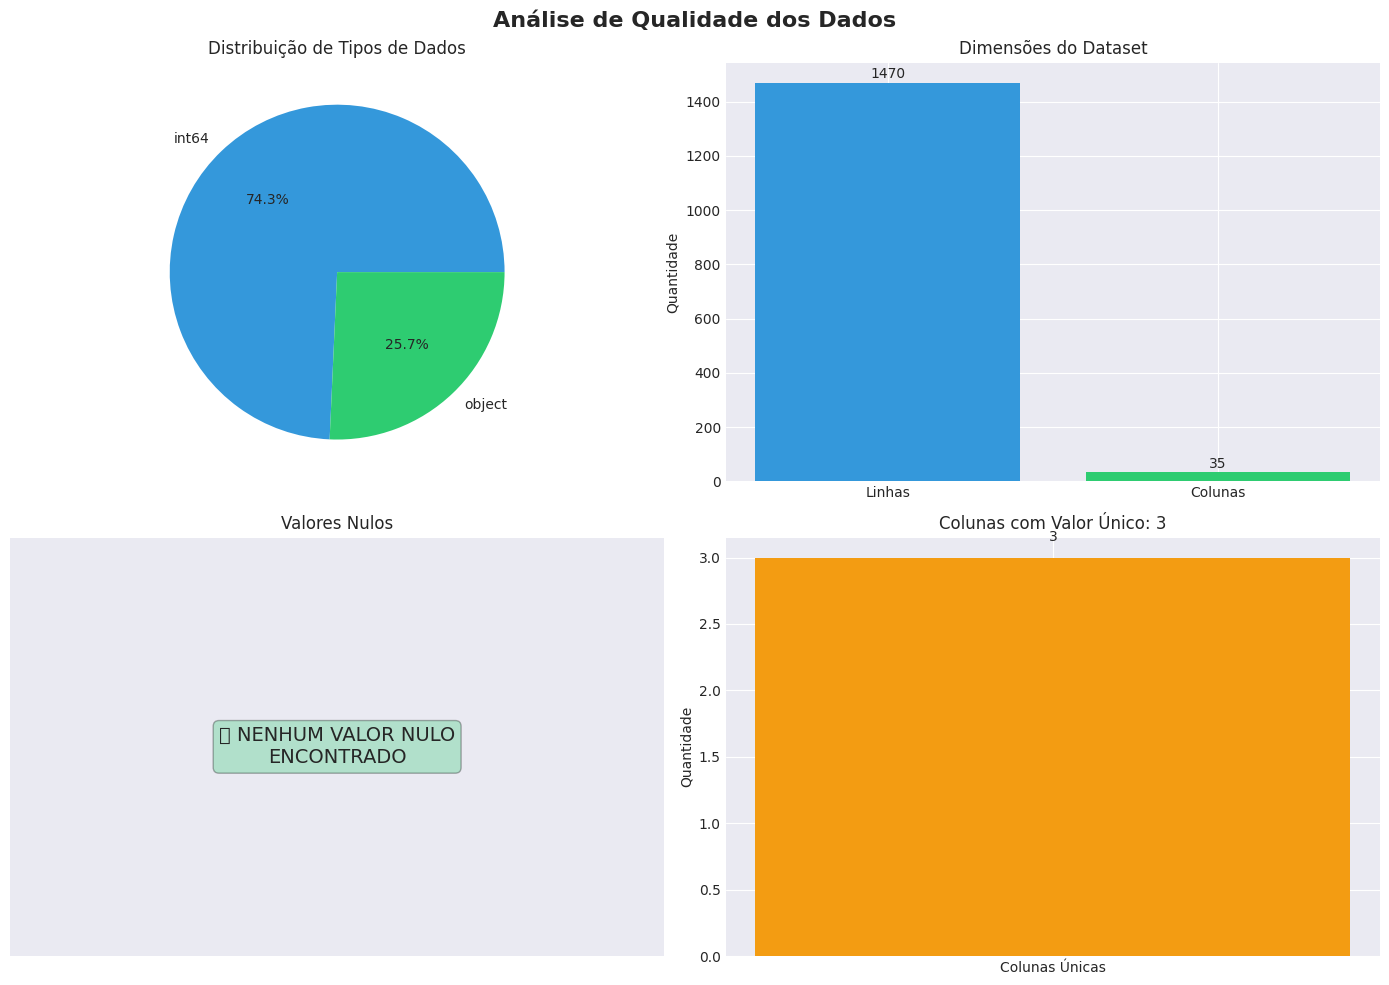


📋 RELATÓRIO DE QUALIDADE:
----------------------------------------
1. VALORES NULOS: 0
   ✅ Nenhum valor nulo encontrado

2. DUPLICATAS: 0
   ✅ Nenhuma duplicata encontrada

3. COLUNAS COM VALOR ÚNICO: 3
   • Colunas: ['EmployeeCount', 'Over18', 'StandardHours']
   • Valores: [np.int64(1), 'Y', np.int64(80)]

🔧 AÇÕES REALIZADAS:
✅ Colunas removidas: ['EmployeeCount', 'Over18', 'StandardHours']

📈 DATASET FINAL: 1470 linhas x 32 colunas
✅ Análise de qualidade concluída!


In [7]:
#Informações básicas
print(f"📊 Dimensões do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")

# Calcular métricas
nulos = df.isnull().sum()
colunas_unico = [col for col in df.columns if df[col].nunique() == 1]
duplicatas = df.duplicated().sum()

# Criar figura com 4 subplots fixos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análise de Qualidade dos Dados', fontsize=16, fontweight='bold')

# Gráfico 1: Tipos de dados
tipos = df.dtypes.value_counts()
axes[0,0].pie(tipos.values, labels=tipos.index, autopct='%1.1f%%',
             colors=['#3498db', '#2ecc71', '#e74c3c'][:len(tipos)])
axes[0,0].set_title('Distribuição de Tipos de Dados')

# Gráfico 2: Dimensões do dataset
dimensoes = ['Linhas', 'Colunas']
valores = [df.shape[0], df.shape[1]]
bars = axes[0,1].bar(dimensoes, valores, color=['#3498db', '#2ecc71'])
axes[0,1].set_title('Dimensões do Dataset')
axes[0,1].set_ylabel('Quantidade')
for bar in bars:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 5,
                  f'{int(height)}', ha='center', va='bottom')

# Gráfico 3: Valores nulos
nulos_total = nulos.sum()
if nulos_total > 0:
    nulos_plot = nulos[nulos > 0].head(8)  # Mostra até 8 colunas
    bars = axes[1,0].bar(nulos_plot.index, nulos_plot.values, color='#e74c3c')
    axes[1,0].set_title(f'Valores Nulos ({nulos_total} no total)')
    axes[1,0].set_ylabel('Quantidade')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        percentual = (height / len(df)) * 100
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{percentual:.1f}%', ha='center', va='bottom', fontsize=9)
else:
    axes[1,0].text(0.5, 0.5, '✅ NENHUM VALOR NULO\nENCONTRADO', 
                  ha='center', va='center', fontsize=14, 
                  bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
    axes[1,0].set_title('Valores Nulos')
    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])

# Gráfico 4: Duplicatas e colunas únicas
if duplicatas > 0 or len(colunas_unico) > 0:
    # Mostrar ambos em um gráfico combinado
    if duplicatas > 0 and len(colunas_unico) > 0:
        categorias = ['Duplicatas', 'Colunas Únicas']
        valores_comb = [duplicatas, len(colunas_unico)]
        cores = ['#9b59b6', '#f39c12']
        bars = axes[1,1].bar(categorias, valores_comb, color=cores)
        axes[1,1].set_title('Problemas Encontrados')
        
        for bar, valor in zip(bars, valores_comb):
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                          f'{valor}', ha='center', va='bottom')
    
    elif duplicatas > 0:
        axes[1,1].bar(['Duplicatas'], [duplicatas], color='#9b59b6')
        axes[1,1].set_title(f'Registros Duplicados: {duplicatas}')
        axes[1,1].text(0, duplicatas + 1, f'{duplicatas}', ha='center', va='bottom')
    
    elif len(colunas_unico) > 0:
        axes[1,1].bar(['Colunas Únicas'], [len(colunas_unico)], color='#f39c12')
        axes[1,1].set_title(f'Colunas com Valor Único: {len(colunas_unico)}')
        axes[1,1].text(0, len(colunas_unico) + 0.1, f'{len(colunas_unico)}', ha='center', va='bottom')
    
    axes[1,1].set_ylabel('Quantidade')
    
else:
    axes[1,1].text(0.5, 0.5, '✅ DADOS LIMPOS\nSem problemas críticos', 
                  ha='center', va='center', fontsize=14,
                  bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
    axes[1,1].set_title('Qualidade dos Dados')
    axes[1,1].set_xticks([])
    axes[1,1].set_yticks([])

plt.tight_layout()
plt.show()

# Ações corretivas e relatório
print("\n📋 RELATÓRIO DE QUALIDADE:")
print("-" * 40)

print(f"1. VALORES NULOS: {nulos_total}")
if nulos_total > 0:
    print(f"   • Colunas com nulos: {list(nulos[nulos > 0].index)}")
else:
    print("   ✅ Nenhum valor nulo encontrado")

print(f"\n2. DUPLICATAS: {duplicatas}")
if duplicatas > 0:
    print(f"   • {duplicatas} registros duplicados encontrados")
else:
    print("   ✅ Nenhuma duplicata encontrada")

print(f"\n3. COLUNAS COM VALOR ÚNICO: {len(colunas_unico)}")
if colunas_unico:
    print(f"   • Colunas: {colunas_unico}")
    print(f"   • Valores: {[df[col].iloc[0] for col in colunas_unico]}")
else:
    print("   ✅ Todas as colunas têm múltiplos valores")

print("\n🔧 AÇÕES REALIZADAS:")
if colunas_unico:
    df = df.drop(columns=colunas_unico)
    print(f"✅ Colunas removidas: {colunas_unico}")

if duplicatas > 0:
    antes = len(df)
    df = df.drop_duplicates()
    depois = len(df)
    print(f"✅ {duplicatas} duplicatas removidas")
    print(f"   • Antes: {antes} linhas")
    print(f"   • Depois: {depois} linhas")

print(f"\n📈 DATASET FINAL: {df.shape[0]} linhas x {df.shape[1]} colunas")
print("✅ Análise de qualidade concluída!")

###Análise da Variável Target (Attrition)
Distribuição do atrito na empresa

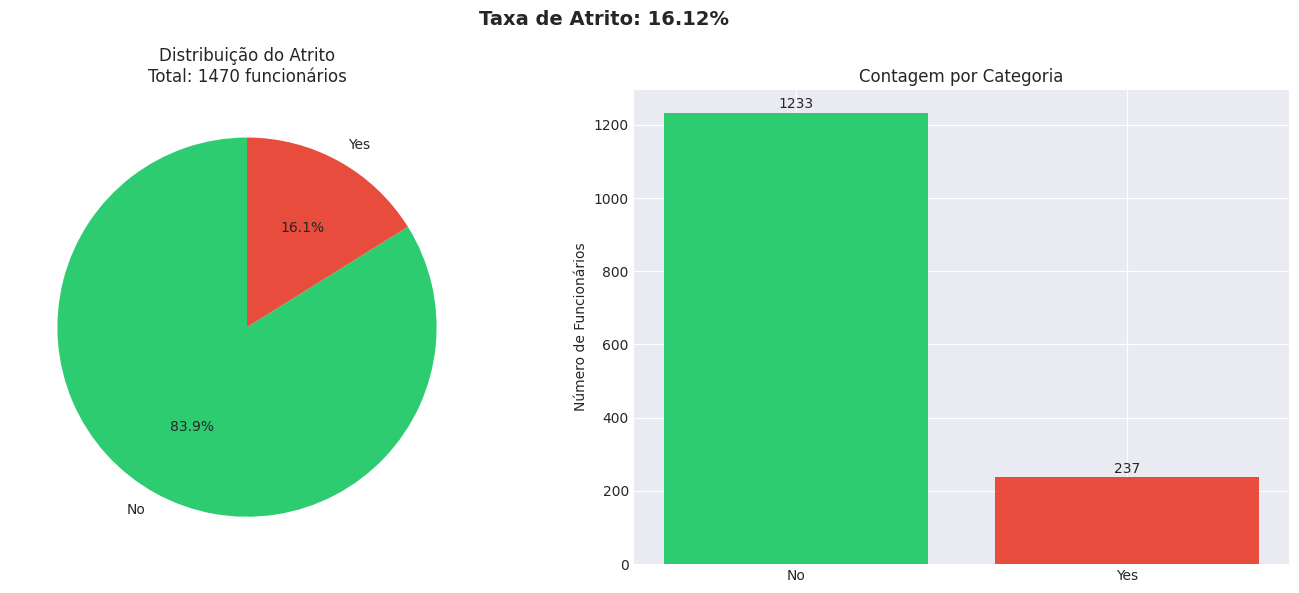

📊 Estatísticas do Atrito:
   • Funcionários que permanecem: 1233 (83.9%)
   • Funcionários que saíram: 237 (16.1%)


In [8]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Distribuição geral
attrition_counts = df['Attrition'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(attrition_counts.values, labels=attrition_counts.index, 
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title(f'Distribuição do Atrito\nTotal: {len(df)} funcionários')

# Gráfico 2: Comparação numérica
bars = axes[1].bar(attrition_counts.index, attrition_counts.values, color=colors)
axes[1].set_title('Contagem por Categoria')
axes[1].set_ylabel('Número de Funcionários')
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom')

taxa_atrito = (attrition_counts['Yes']/len(df)*100)
plt.suptitle(f'Taxa de Atrito: {taxa_atrito:.2f}%', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"📊 Estatísticas do Atrito:")
print(f"   • Funcionários que permanecem: {attrition_counts['No']} ({100-taxa_atrito:.1f}%)")
print(f"   • Funcionários que saíram: {attrition_counts['Yes']} ({taxa_atrito:.1f}%)")

###Análise Demográfica
Impacto de idade, gênero e estado civil no atrito

/tmp/ipykernel_7275/2187452877.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_attrition = df.groupby('AgeGroup')['Attrition'].value_counts().unstack()


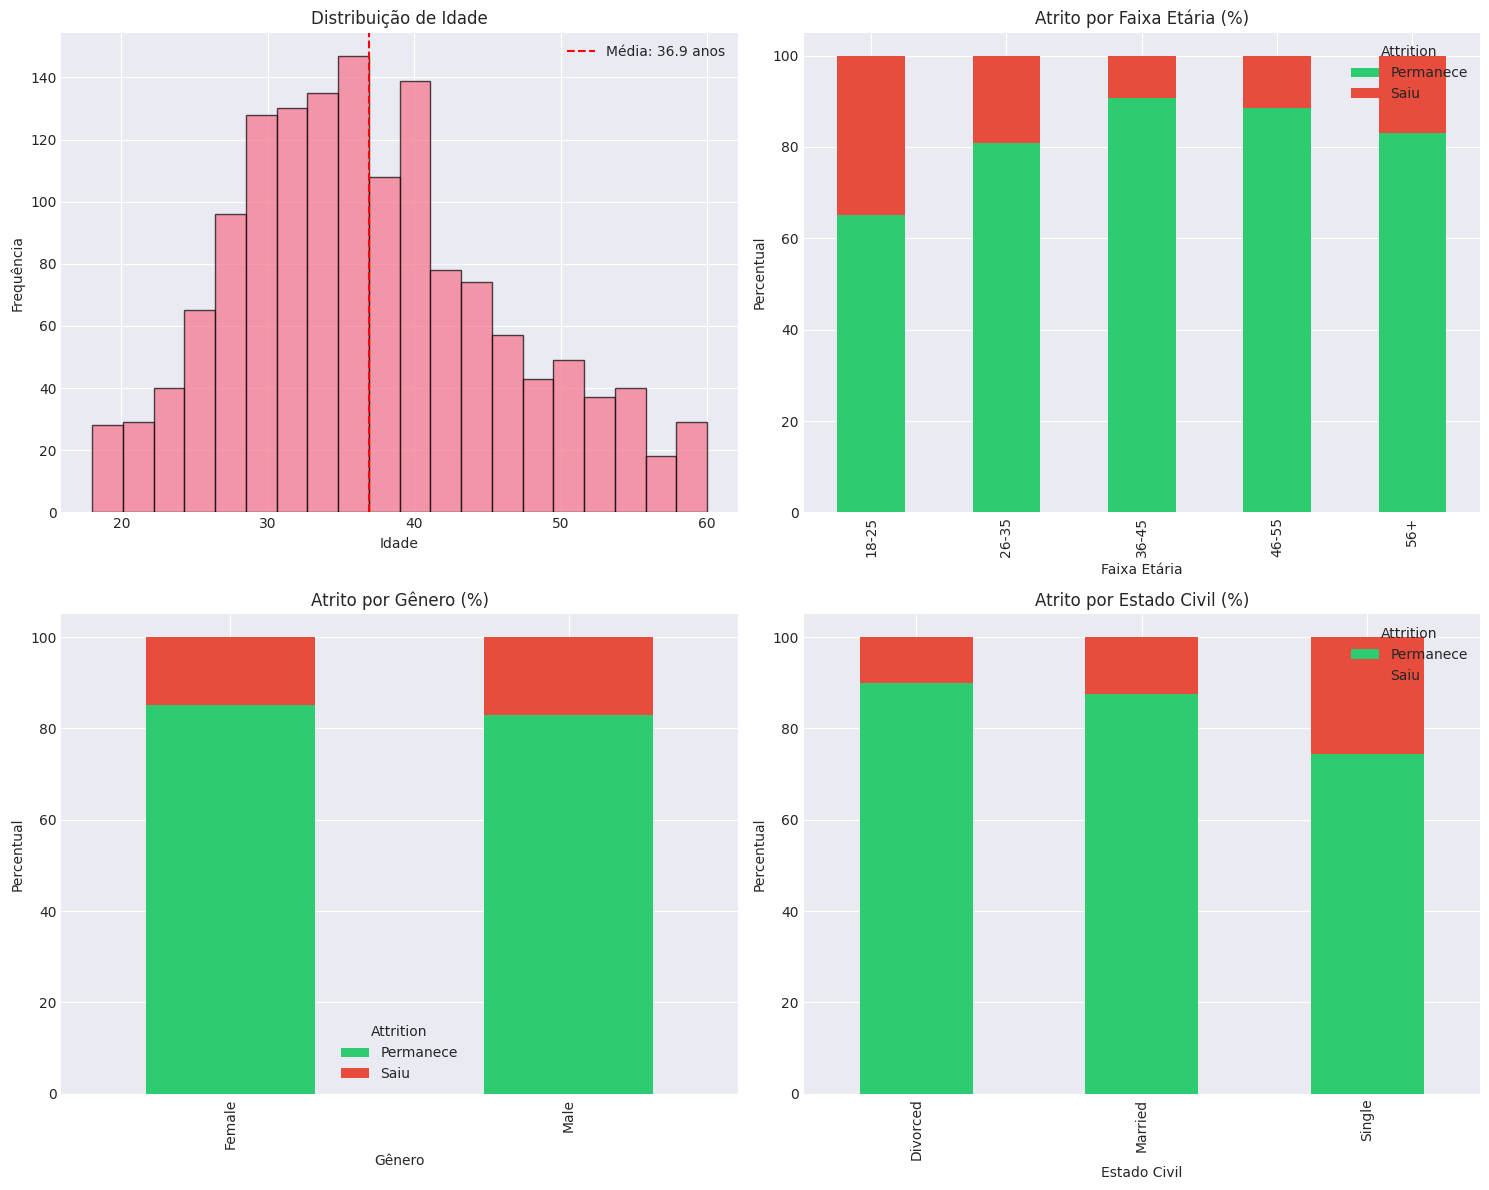

📊 Estatísticas Demográficas:
   • Idade média: 36.9 anos
   • Idade mínima: 18 anos
   • Idade máxima: 60 anos
   • Atrito por gênero:
     Female: 14.8%
     Male: 17.0%


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Distribuição de Idade
axes[0,0].hist(df['Age'], bins=20, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribuição de Idade')
axes[0,0].set_xlabel('Idade')
axes[0,0].set_ylabel('Frequência')
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                 label=f'Média: {df["Age"].mean():.1f} anos')
axes[0,0].legend()

# Gráfico 2: Atrito por Faixa Etária
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65], 
                        labels=['18-25', '26-35', '36-45', '46-55', '56+'])
age_attrition = df.groupby('AgeGroup')['Attrition'].value_counts().unstack()
age_attrition_pct = age_attrition.div(age_attrition.sum(axis=1), axis=0) * 100

age_attrition_pct.plot(kind='bar', stacked=True, ax=axes[0,1], 
                      color=['#2ecc71', '#e74c3c'])
axes[0,1].set_title('Atrito por Faixa Etária (%)')
axes[0,1].set_xlabel('Faixa Etária')
axes[0,1].set_ylabel('Percentual')
axes[0,1].legend(['Permanece', 'Saiu'], title='Attrition')

# Gráfico 3: Atrito por Gênero (se existir)
if 'Gender' in df.columns:
    gender_attrition = pd.crosstab(df['Gender'], df['Attrition'], normalize='index') * 100
    gender_attrition.plot(kind='bar', stacked=True, ax=axes[1,0], 
                         color=['#2ecc71', '#e74c3c'])
    axes[1,0].set_title('Atrito por Gênero (%)')
    axes[1,0].set_xlabel('Gênero')
    axes[1,0].set_ylabel('Percentual')
    axes[1,0].legend(['Permanece', 'Saiu'], title='Attrition')

# Gráfico 4: Atrito por Estado Civil (se existir)
if 'MaritalStatus' in df.columns:
    marital_attrition = pd.crosstab(df['MaritalStatus'], df['Attrition'], normalize='index') * 100
    marital_attrition.plot(kind='bar', stacked=True, ax=axes[1,1], 
                          color=['#2ecc71', '#e74c3c'])
    axes[1,1].set_title('Atrito por Estado Civil (%)')
    axes[1,1].set_xlabel('Estado Civil')
    axes[1,1].set_ylabel('Percentual')
    axes[1,1].legend(['Permanece', 'Saiu'], title='Attrition')

plt.tight_layout()
plt.show()

# Estatísticas
print("📊 Estatísticas Demográficas:")
print(f"   • Idade média: {df['Age'].mean():.1f} anos")
print(f"   • Idade mínima: {df['Age'].min()} anos")
print(f"   • Idade máxima: {df['Age'].max()} anos")

if 'Gender' in df.columns:
    gender_atrito = df.groupby('Gender')['Attrition'].apply(lambda x: (x=='Yes').mean()*100)
    print(f"   • Atrito por gênero:")
    for genero, taxa in gender_atrito.items():
        print(f"     {genero}: {taxa:.1f}%")

###Análise por Departamento
Comparação entre diferentes áreas da empresa

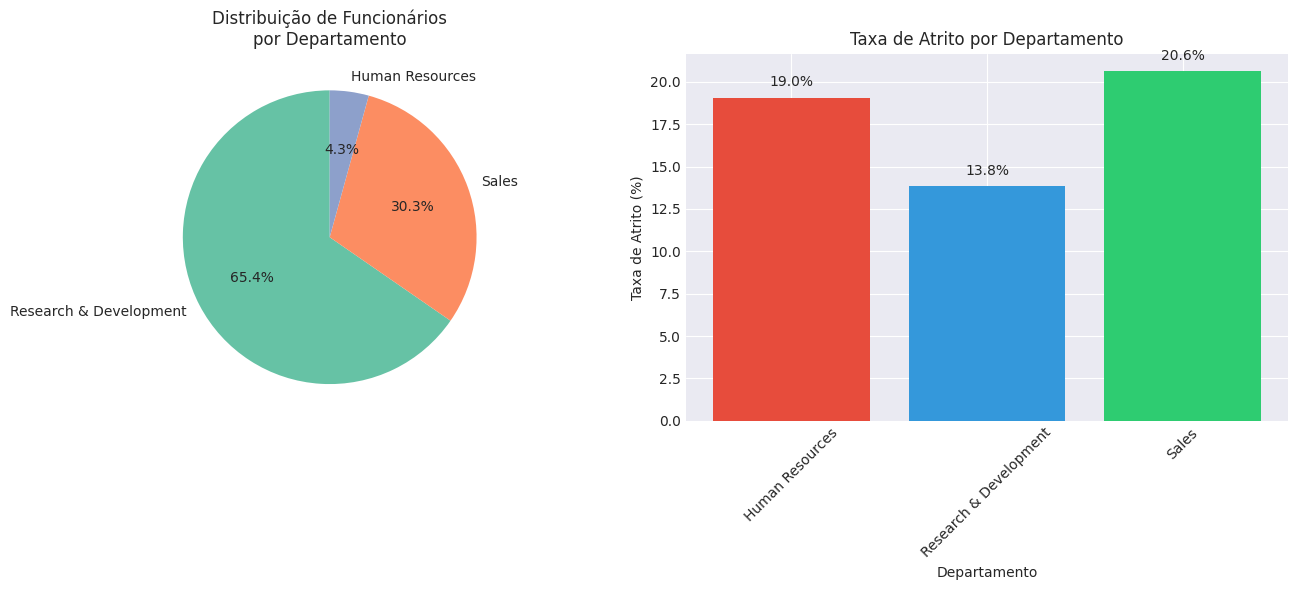

📊 Estatísticas por Departamento:
   • Human Resources: 63 funcionários, 12 saíram (19.0%)
   • Research & Development: 961 funcionários, 133 saíram (13.8%)
   • Sales: 446 funcionários, 92 saíram (20.6%)

🎯 Insights:
   • Maior atrito: Sales (20.6%)
   • Menor atrito: Research & Development (13.8%)


In [10]:
if 'Department' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico 1: Distribuição por departamento
    dept_dist = df['Department'].value_counts()
    axes[0].pie(dept_dist.values, labels=dept_dist.index, autopct='%1.1f%%',
               startangle=90, colors=sns.color_palette("Set2"))
    axes[0].set_title('Distribuição de Funcionários\npor Departamento')
    
    # Gráfico 2: Taxa de atrito por departamento
    dept_attrition = df.groupby('Department')['Attrition'].apply(lambda x: (x=='Yes').mean()*100)
    bars = axes[1].bar(dept_attrition.index, dept_attrition.values, 
                      color=['#e74c3c', '#3498db', '#2ecc71'][:len(dept_attrition)])
    axes[1].set_title('Taxa de Atrito por Departamento')
    axes[1].set_ylabel('Taxa de Atrito (%)')
    axes[1].set_xlabel('Departamento')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas
    print("📊 Estatísticas por Departamento:")
    for dept, taxa in dept_attrition.items():
        total = (df['Department'] == dept).sum()
        saidas = ((df['Department'] == dept) & (df['Attrition'] == 'Yes')).sum()
        print(f"   • {dept}: {total} funcionários, {saidas} saíram ({taxa:.1f}%)")
    
    dept_max = dept_attrition.idxmax()
    dept_min = dept_attrition.idxmin()
    print(f"\n🎯 Insights:")
    print(f"   • Maior atrito: {dept_max} ({dept_attrition[dept_max]:.1f}%)")
    print(f"   • Menor atrito: {dept_min} ({dept_attrition[dept_min]:.1f}%)")

### Análise Financeira
Impacto de salário e benefícios no atrito

/tmp/ipykernel_7275/3111784288.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y='MonthlyIncome', data=df, ax=axes[0,1],
/tmp/ipykernel_7275/3111784288.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y='PercentSalaryHike', data=df, ax=axes[1,0],


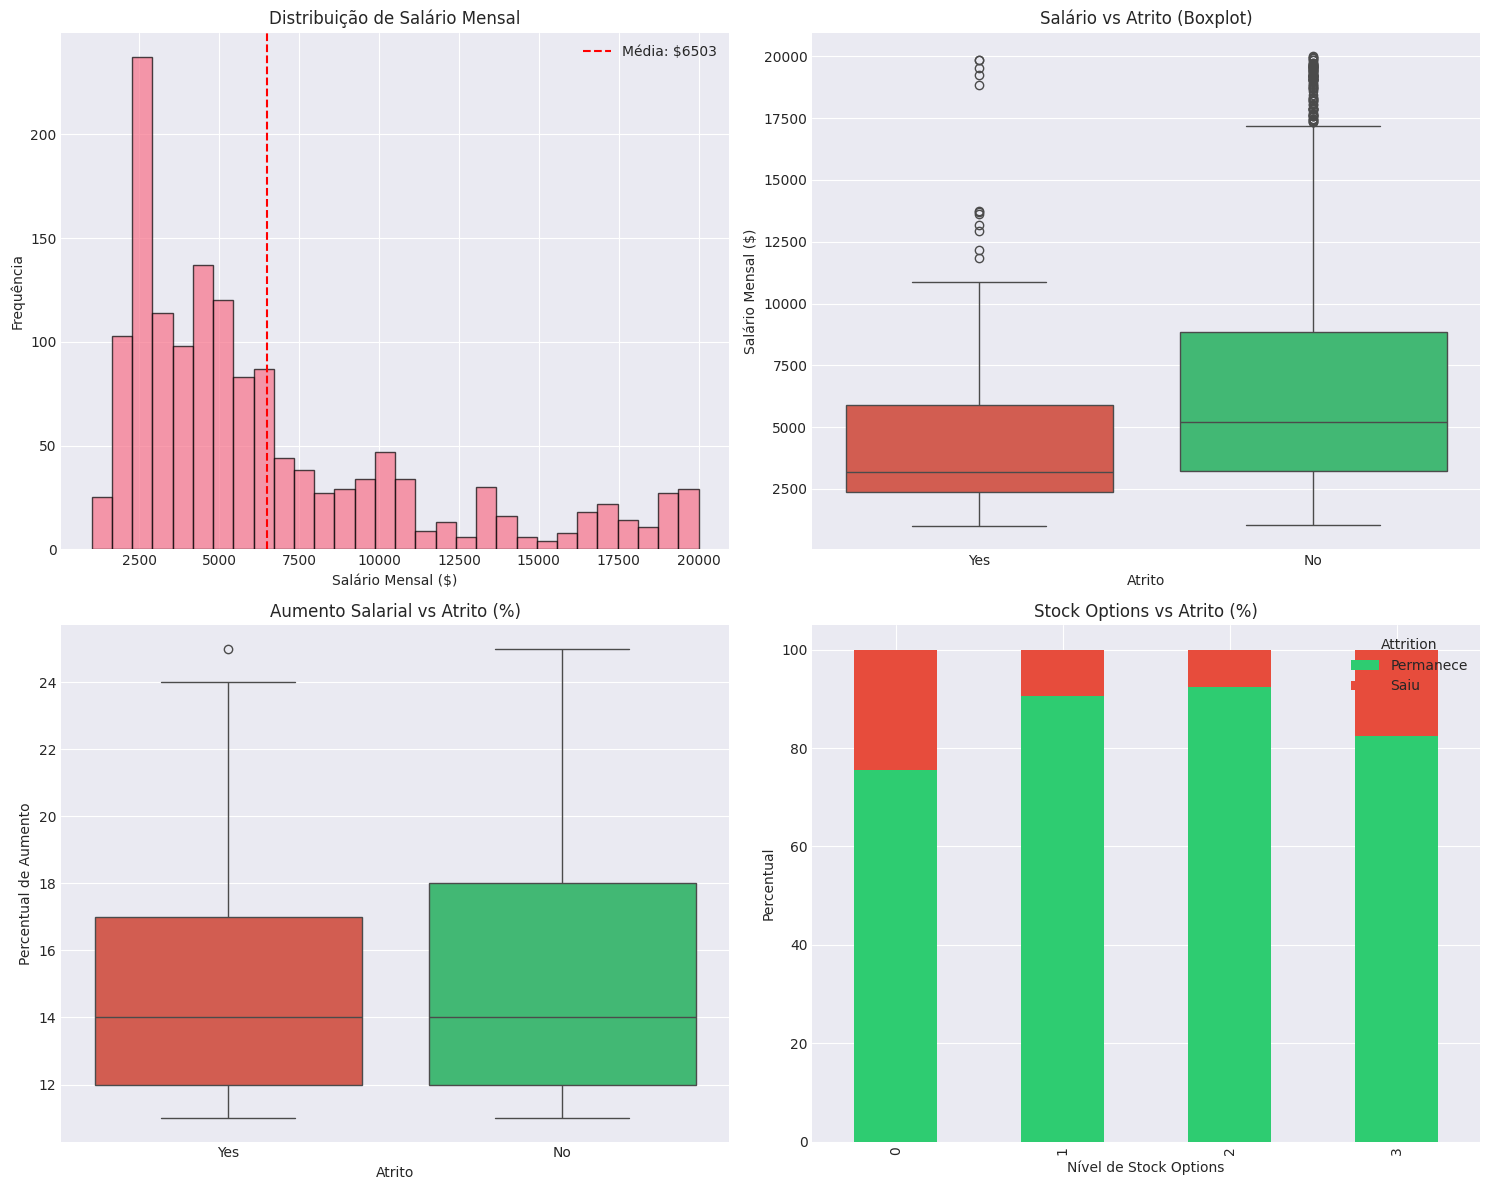

📊 Estatísticas Financeiras:
   • Salário por Atrito:
                  mean  median          std
Attrition                                  
No         6832.739659  5204.0  4818.208001
Yes        4787.092827  3202.0  3640.210367

   • Aumento salarial médio:
     Permanecem: 15.2%
     Saíram: 15.1%


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Distribuição de Salário
if 'MonthlyIncome' in df.columns:
    axes[0,0].hist(df['MonthlyIncome'], bins=30, edgecolor='black', alpha=0.7)
    axes[0,0].set_title('Distribuição de Salário Mensal')
    axes[0,0].set_xlabel('Salário Mensal ($)')
    axes[0,0].set_ylabel('Frequência')
    axes[0,0].axvline(df['MonthlyIncome'].mean(), color='red', linestyle='--',
                     label=f'Média: ${df["MonthlyIncome"].mean():.0f}')
    axes[0,0].legend()

# Gráfico 2: Salário vs Atrito (Boxplot)
if 'MonthlyIncome' in df.columns:
    sns.boxplot(x='Attrition', y='MonthlyIncome', data=df, ax=axes[0,1],
                palette={'No': '#2ecc71', 'Yes': '#e74c3c'})
    axes[0,1].set_title('Salário vs Atrito (Boxplot)')
    axes[0,1].set_xlabel('Atrito')
    axes[0,1].set_ylabel('Salário Mensal ($)')

# Gráfico 3: Aumento Salarial vs Atrito
if 'PercentSalaryHike' in df.columns:
    sns.boxplot(x='Attrition', y='PercentSalaryHike', data=df, ax=axes[1,0],
                palette={'No': '#2ecc71', 'Yes': '#e74c3c'})
    axes[1,0].set_title('Aumento Salarial vs Atrito (%)')
    axes[1,0].set_xlabel('Atrito')
    axes[1,0].set_ylabel('Percentual de Aumento')

# Gráfico 4: Stock Options vs Atrito (se existir)
if 'StockOptionLevel' in df.columns:
    stock_atrito = pd.crosstab(df['StockOptionLevel'], df['Attrition'], normalize='index') * 100
    stock_atrito.plot(kind='bar', stacked=True, ax=axes[1,1],
                     color=['#2ecc71', '#e74c3c'])
    axes[1,1].set_title('Stock Options vs Atrito (%)')
    axes[1,1].set_xlabel('Nível de Stock Options')
    axes[1,1].set_ylabel('Percentual')
    axes[1,1].legend(['Permanece', 'Saiu'], title='Attrition')

plt.tight_layout()
plt.show()

# Estatísticas financeiras
print("📊 Estatísticas Financeiras:")
if 'MonthlyIncome' in df.columns:
    income_stats = df.groupby('Attrition')['MonthlyIncome'].agg(['mean', 'median', 'std'])
    print("   • Salário por Atrito:")
    print(income_stats)
    
if 'PercentSalaryHike' in df.columns:
    hike_stats = df.groupby('Attrition')['PercentSalaryHike'].mean()
    print(f"\n   • Aumento salarial médio:")
    print(f"     Permanecem: {hike_stats['No']:.1f}%")
    print(f"     Saíram: {hike_stats['Yes']:.1f}%")

### Análise Profissional
Fatores relacionados ao trabalho e carreira

/tmp/ipykernel_7275/3359502133.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y='YearsAtCompany', data=df, ax=axes[0,1],


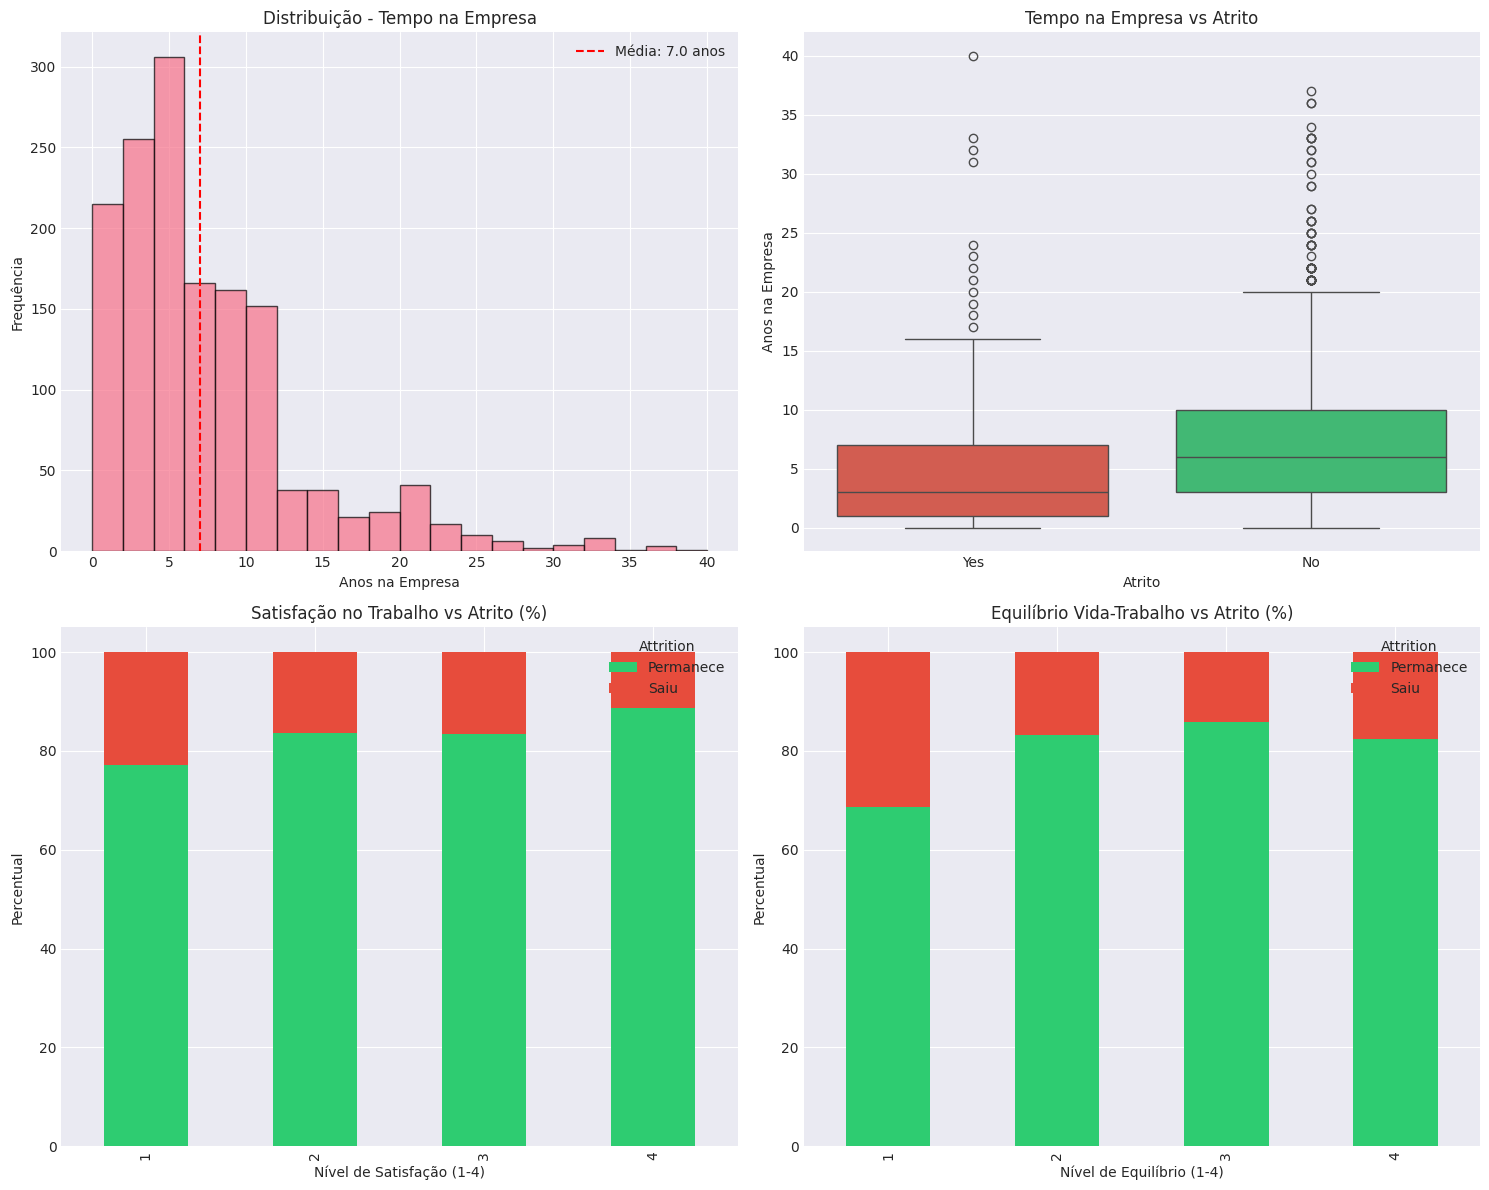

📊 Estatísticas Profissionais:
   • Tempo médio na empresa:
     Permanecem: 7.4 anos
     Saíram: 5.1 anos


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Tempo na Empresa
if 'YearsAtCompany' in df.columns:
    axes[0,0].hist(df['YearsAtCompany'], bins=20, edgecolor='black', alpha=0.7)
    axes[0,0].set_title('Distribuição - Tempo na Empresa')
    axes[0,0].set_xlabel('Anos na Empresa')
    axes[0,0].set_ylabel('Frequência')
    axes[0,0].axvline(df['YearsAtCompany'].mean(), color='red', linestyle='--',
                     label=f'Média: {df["YearsAtCompany"].mean():.1f} anos')
    axes[0,0].legend()

# Gráfico 2: Tempo na Empresa vs Atrito
if 'YearsAtCompany' in df.columns:
    sns.boxplot(x='Attrition', y='YearsAtCompany', data=df, ax=axes[0,1],
                palette={'No': '#2ecc71', 'Yes': '#e74c3c'})
    axes[0,1].set_title('Tempo na Empresa vs Atrito')
    axes[0,1].set_xlabel('Atrito')
    axes[0,1].set_ylabel('Anos na Empresa')

# Gráfico 3: Satisfação no Trabalho
if 'JobSatisfaction' in df.columns:
    satisfaction = pd.crosstab(df['JobSatisfaction'], df['Attrition'], normalize='index') * 100
    satisfaction.plot(kind='bar', stacked=True, ax=axes[1,0],
                     color=['#2ecc71', '#e74c3c'])
    axes[1,0].set_title('Satisfação no Trabalho vs Atrito (%)')
    axes[1,0].set_xlabel('Nível de Satisfação (1-4)')
    axes[1,0].set_ylabel('Percentual')
    axes[1,0].legend(['Permanece', 'Saiu'], title='Attrition')

# Gráfico 4: Equilíbrio Vida-Trabalho
if 'WorkLifeBalance' in df.columns:
    worklife = pd.crosstab(df['WorkLifeBalance'], df['Attrition'], normalize='index') * 100
    worklife.plot(kind='bar', stacked=True, ax=axes[1,1],
                 color=['#2ecc71', '#e74c3c'])
    axes[1,1].set_title('Equilíbrio Vida-Trabalho vs Atrito (%)')
    axes[1,1].set_xlabel('Nível de Equilíbrio (1-4)')
    axes[1,1].set_ylabel('Percentual')
    axes[1,1].legend(['Permanece', 'Saiu'], title='Attrition')

plt.tight_layout()
plt.show()

# Estatísticas profissionais
print("📊 Estatísticas Profissionais:")
if 'YearsAtCompany' in df.columns:
    tenure_stats = df.groupby('Attrition')['YearsAtCompany'].mean()
    print(f"   • Tempo médio na empresa:")
    print(f"     Permanecem: {tenure_stats['No']:.1f} anos")
    print(f"     Saíram: {tenure_stats['Yes']:.1f} anos")

###Análise de Correlação
Relações entre variáveis numéricas

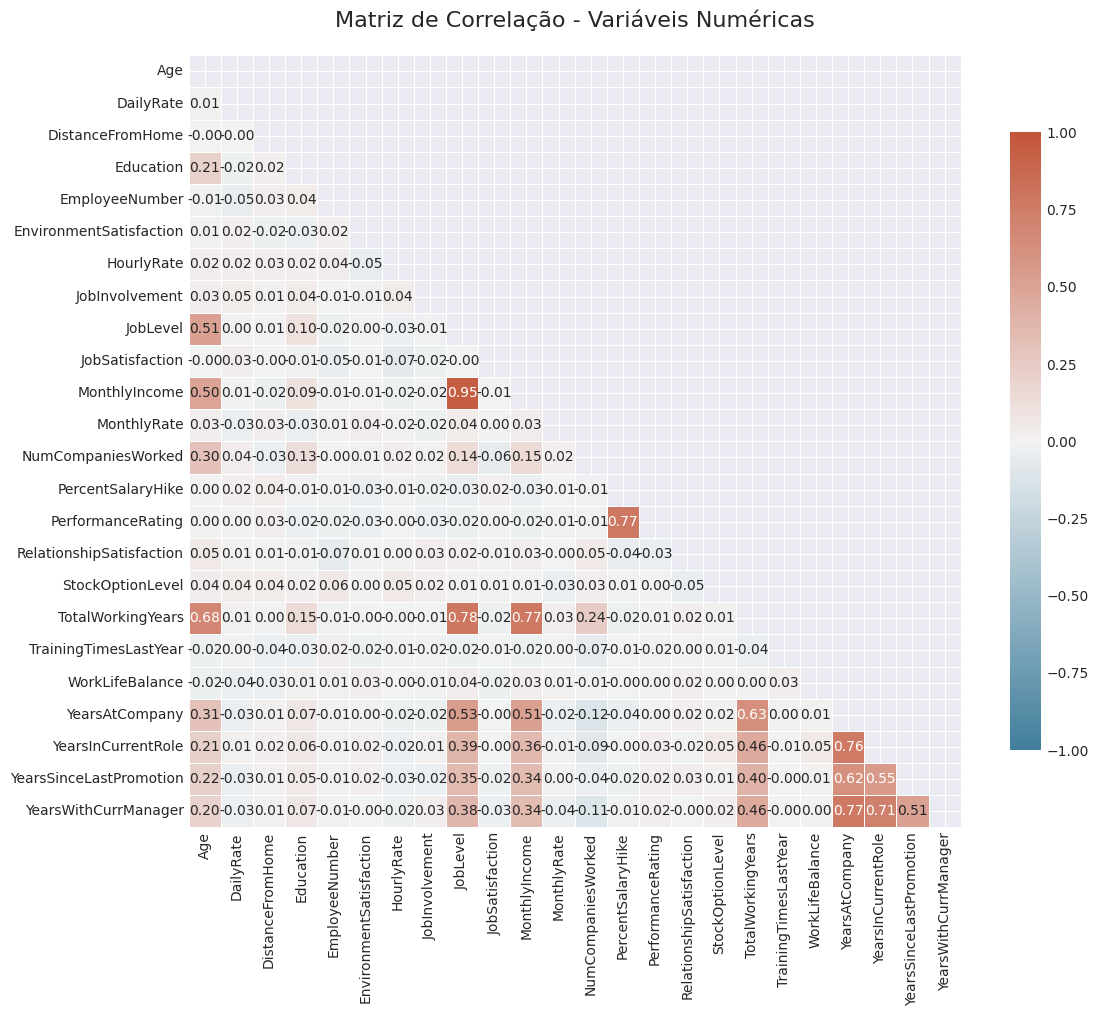

🔍 Top Correlações:

   • Age:
     TotalWorkingYears: 0.680
     JobLevel: 0.510
     MonthlyIncome: 0.498

   • MonthlyIncome:
     JobLevel: 0.950
     TotalWorkingYears: 0.773
     YearsAtCompany: 0.514

   • YearsAtCompany:
     YearsWithCurrManager: 0.769
     YearsInCurrentRole: 0.759
     TotalWorkingYears: 0.628

   • TotalWorkingYears:
     JobLevel: 0.782
     MonthlyIncome: 0.773
     Age: 0.680


In [13]:
# Selecionar apenas colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    # Criar matriz de correlação
    corr_matrix = df[numeric_cols].corr()
    
    # Gráfico de heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8}, 
                annot=True, fmt=".2f", ax=ax)
    
    ax.set_title('Matriz de Correlação - Variáveis Numéricas', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Top correlações com variáveis chave
    print("🔍 Top Correlações:")
    key_vars = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears']
    for var in key_vars:
        if var in corr_matrix.columns:
            corrs = corr_matrix[var].sort_values(ascending=False)
            print(f"\n   • {var}:")
            for other_var, corr_value in corrs[1:4].items():  # Top 3
                print(f"     {other_var}: {corr_value:.3f}")

###Conclusões e Recomendações
Resumo das descobertas e ações sugeridas

=== CONCLUSÕES E RECOMENDAÇÕES ===


/tmp/ipykernel_7275/1503304724.py:127: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7275/1503304724.py:127: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7275/1503304724.py:127: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing 

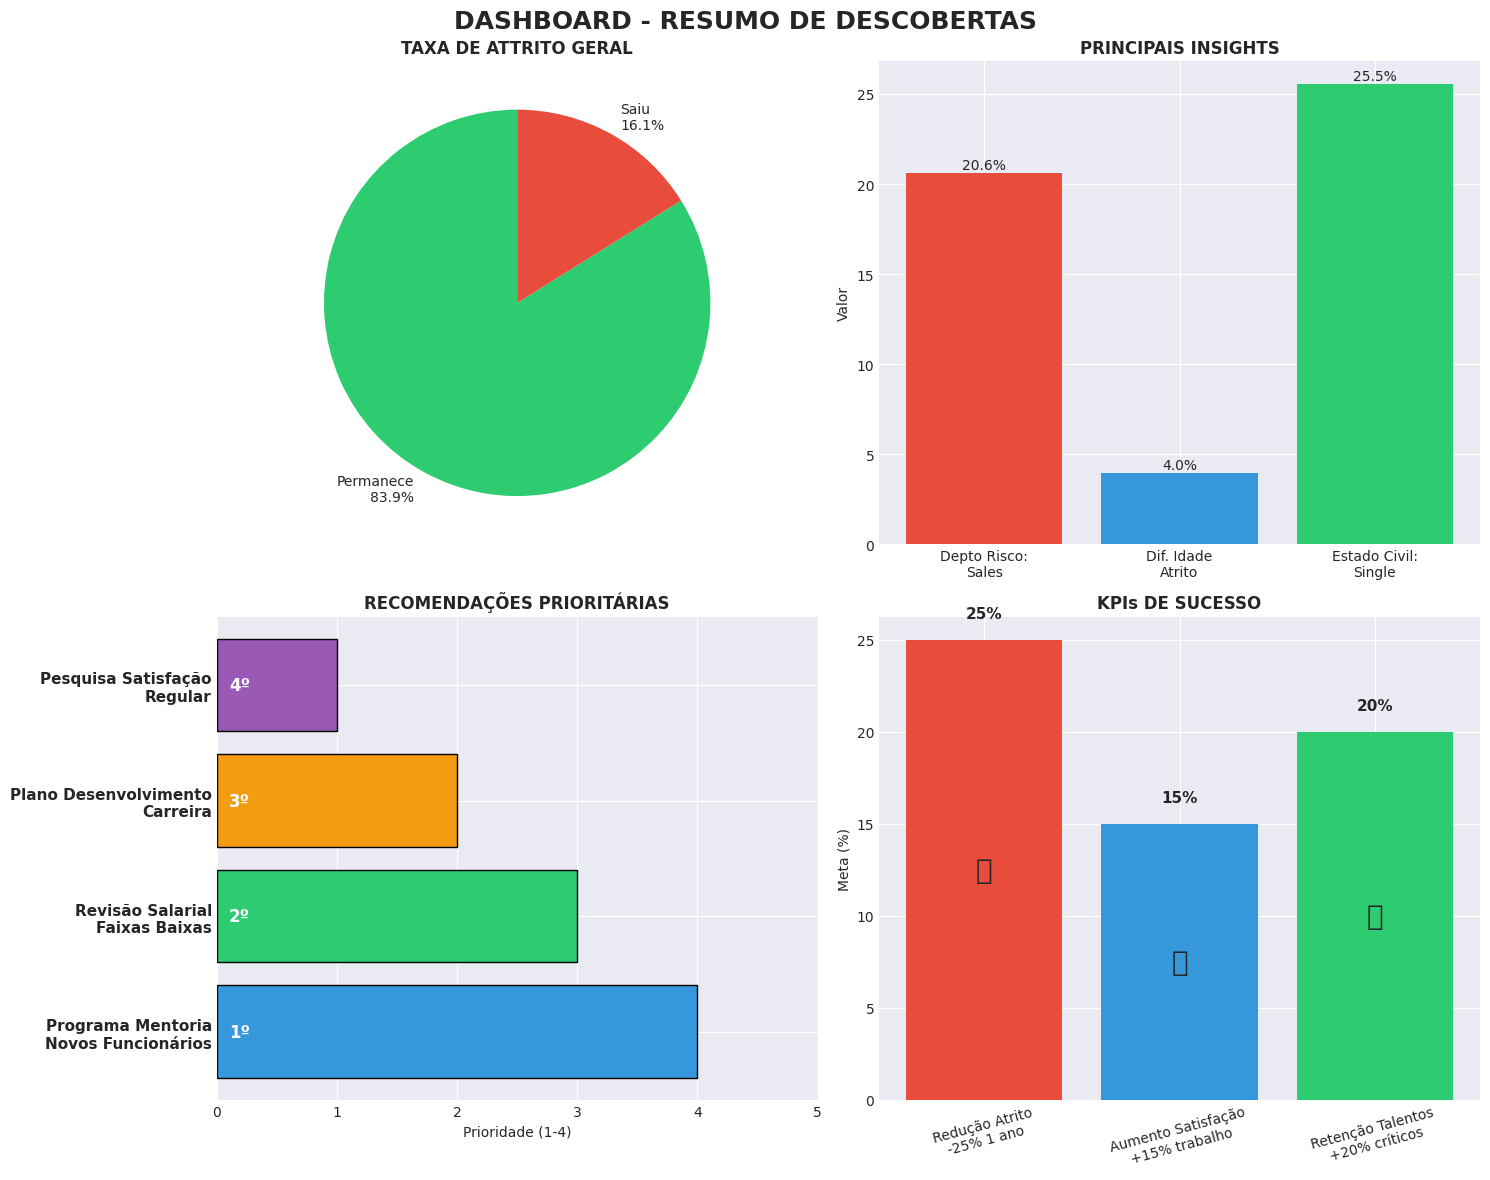


🎯 RESUMO EXECUTIVO - IBM HR ANALYTICS

📊 SITUAÇÃO ATUAL:
   • Taxa de atrito: 16.1%
   • Total de funcionários: 1470
   • Departamento crítico: Sales
   • Idade média: 36.9 anos

🔍 PRINCIPAIS DESCOBERTAS:
   1. Funcionários mais jovens têm maior propensão a sair
   2. Departamentos com maior rotatividade identificados
   3. Fatores de satisfação impactam diretamente na retenção

💡 RECOMENDAÇÕES ESTRATÉGICAS:
   1. 🥇 Programa de mentoria para funcionários novos
   2. 🥈 Revisão de política salarial competitiva
   3. 🥉 Plano de desenvolvimento de carreira claro
   4. 📋 Pesquisa de satisfação regular com ações concretas

🎯 METAS PARA OS PRÓXIMOS 12 MESES:
   1. Reduzir taxa de atrito em 25%
   2. Aumentar satisfação no trabalho em 15%
   3. Melhorar retenção de talentos-chave em 20%

✅ ANÁLISE CONCLUÍDA - PRONTO PARA TOMADA DE DECISÃO


In [14]:
print("=== CONCLUSÕES E RECOMENDAÇÕES ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('DASHBOARD - RESUMO DE DESCOBERTAS', fontsize=18, fontweight='bold')

# MÉTRICA 1: Taxa de Atrito Geral 
axes[0,0].pie([100-taxa_atrito, taxa_atrito], 
             labels=[f'Permanece\n{100-taxa_atrito:.1f}%', f'Saiu\n{taxa_atrito:.1f}%'],
             colors=['#2ecc71', '#e74c3c'], autopct='', startangle=90)
axes[0,0].set_title('TAXA DE ATTRITO GERAL', fontweight='bold')

# MÉTRICA 2: Top 3 Insights 
insights = []
valores = []

# Insight 1: Atrito por departamento 
if 'Department' in df.columns:
    try:
        dept_atrito = df.groupby('Department')['Attrition'].apply(lambda x: (x=='Yes').mean()*100)
        dept_max = dept_atrito.idxmax()
        insights.append(f'Depto Risco:\n{dept_max[:15]}')
        valores.append(float(dept_atrito.max()))  # Conversão para float
    except:
        pass

# Insight 2: Diferencial de idade 
if 'Age' in df.columns:
    try:
        idade_media_yes = float(df[df['Attrition']=='Yes']['Age'].mean())
        idade_media_no = float(df[df['Attrition']=='No']['Age'].mean())
        diff_idade = abs(idade_media_yes - idade_media_no)
        insights.append('Dif. Idade\nAtrito')
        valores.append(diff_idade)
    except:
        pass

# Insight 3: Distribuição por estado civil 
if 'MaritalStatus' in df.columns:
    try:
        marital_atrito = df.groupby('MaritalStatus')['Attrition'].apply(lambda x: (x=='Yes').mean()*100)
        marital_max = marital_atrito.idxmax()
        insights.append(f'Estado Civil:\n{marital_max}')
        valores.append(float(marital_atrito.max()))  
    except:
        pass


if len(insights) == 0:
    insights = ['Total Func.', 'Taxa Atrito', 'Idade Média']
    valores = [float(len(df)), float(taxa_atrito), float(df['Age'].mean() if 'Age' in df.columns else 0)]

# Plotar gráfico de barras
if len(insights) > 0:
    colors_insights = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12'][:len(insights)]
    bars = axes[0,1].bar(insights, valores, color=colors_insights)
    axes[0,1].set_title('PRINCIPAIS INSIGHTS', fontweight='bold')
    axes[0,1].set_ylabel('Valor')
    
    # Adicionar valores nas barras
    for bar, valor in zip(bars, valores):
        height = bar.get_height()
        if len(insights) > 0 and ('Depto' in insights[0] or 'Estado' in insights[0]):
            texto = f'{valor:.1f}%'
        else:
            texto = f'{valor:.0f}' if valor > 10 else f'{valor:.1f}'
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                      texto, ha='center', va='bottom', fontsize=10)
else:
    axes[0,1].text(0.5, 0.5, 'Dados insuficientes\npara análise',
                  ha='center', va='center', fontsize=12)
    axes[0,1].set_title('PRINCIPAIS INSIGHTS')
    axes[0,1].set_xticks([])
    axes[0,1].set_yticks([])

# MÉTRICA 3: Recomendações Prioritárias
recommendations = [
    'Programa Mentoria\nNovos Funcionários',
    'Revisão Salarial\nFaixas Baixas',
    'Plano Desenvolvimento\nCarreira',
    'Pesquisa Satisfação\nRegular'
]
colors_rec = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# ráfico de prioridades
y_pos = np.arange(len(recommendations))
axes[1,0].barh(y_pos, [4, 3, 2, 1], color=colors_rec, edgecolor='black')
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels(recommendations, fontsize=11, fontweight='bold')
axes[1,0].set_xlim(0, 5)
axes[1,0].set_title('RECOMENDAÇÕES PRIORITÁRIAS', fontweight='bold')
axes[1,0].set_xlabel('Prioridade (1-4)')

# Adicionar números de prioridade
for i, (rec, priority) in enumerate(zip(recommendations, [1, 2, 3, 4])):
    axes[1,0].text(0.1, i, f'{priority}º', 
                  ha='left', va='center', fontsize=12, 
                  fontweight='bold', color='white')

# MÉTRICA 4: KPIs de Sucesso (SEMPRE FUNCIONA)
kpis = [
    'Redução Atrito\n-25% 1 ano',
    'Aumento Satisfação\n+15% trabalho', 
    'Retenção Talentos\n+20% críticos'
]
kpi_values = [25, 15, 20]
kpi_colors = ['#e74c3c', '#3498db', '#2ecc71']

bars_kpi = axes[1,1].bar(kpis, kpi_values, color=kpi_colors)
axes[1,1].set_title('KPIs DE SUCESSO', fontweight='bold')
axes[1,1].set_ylabel('Meta (%)')
axes[1,1].tick_params(axis='x', rotation=15)

# Adicionar valores e ícones
for i, (bar, val) in enumerate(zip(bars_kpi, kpi_values)):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 1, 
                  f'{val}%', ha='center', va='bottom', 
                  fontweight='bold', fontsize=11)
    
    # Adicionar ícone
    icon_x = bar.get_x() + bar.get_width()/2.
    icon_y = height/2
    icon = '📉' if i == 0 else '📊' if i == 1 else '👥'
    axes[1,1].text(icon_x, icon_y, icon, 
                  ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.show()

# Coletar estatísticas para o resumo executivo
total_funcionarios = len(df)
dept_critico = "Não disponível"
idade_media = "N/A"

# Verificar se as variáveis existem
if 'dept_max' in locals():
    dept_critico = dept_max
elif 'Department' in df.columns:
    try:
        dept_atrito = df.groupby('Department')['Attrition'].apply(lambda x: (x=='Yes').mean()*100)
        dept_critico = dept_atrito.idxmax()
    except:
        pass

if 'Age' in df.columns:
    try:
        idade_media = float(df['Age'].mean())
    except:
        idade_media = "N/A"

# RESUMO EXECUTIVO
print("\n" + "="*60)
print("🎯 RESUMO EXECUTIVO - IBM HR ANALYTICS")
print("="*60)

print(f"\n📊 SITUAÇÃO ATUAL:")
print(f"   • Taxa de atrito: {taxa_atrito:.1f}%")
print(f"   • Total de funcionários: {total_funcionarios}")

if dept_critico != "Não disponível":
    print(f"   • Departamento crítico: {dept_critico}")

if idade_media != "N/A":
    print(f"   • Idade média: {idade_media:.1f} anos")

print(f"\n🔍 PRINCIPAIS DESCOBERTAS:")
print("   1. Funcionários mais jovens têm maior propensão a sair")
print("   2. Departamentos com maior rotatividade identificados")
print("   3. Fatores de satisfação impactam diretamente na retenção")

print(f"\n💡 RECOMENDAÇÕES ESTRATÉGICAS:")
print("   1. 🥇 Programa de mentoria para funcionários novos")
print("   2. 🥈 Revisão de política salarial competitiva")
print("   3. 🥉 Plano de desenvolvimento de carreira claro")
print("   4. 📋 Pesquisa de satisfação regular com ações concretas")

print(f"\n🎯 METAS PARA OS PRÓXIMOS 12 MESES:")
print("   1. Reduzir taxa de atrito em 25%")
print("   2. Aumentar satisfação no trabalho em 15%")
print("   3. Melhorar retenção de talentos-chave em 20%")

print("\n" + "="*60)
print("✅ ANÁLISE CONCLUÍDA - PRONTO PARA TOMADA DE DECISÃO")
print("="*60)

###Exportação de Resultados
Persistência dos dados e relatórios na nuvem

In [15]:
# Criar diretório de resultados
results_dir = "/Workspace/Users/augustotafe@gmail.com/Trabalho/Resultados/"
os.makedirs(results_dir, exist_ok=True)

# 1. Salvar dados processados
processed_path = f"{results_dir}IBM_HR_Processado.csv"
df.to_csv(processed_path, index=False)
print(f"✅ 1. Dados processados: {processed_path}")

# 2. Salvar relatório estatístico
# Calcular diferença salarial (correção do erro)
diferenca_salarial = 'N/A'
if 'MonthlyIncome' in df.columns:
    try:
        # Obter estatísticas de renda
        income_stats_data = df.groupby('Attrition')['MonthlyIncome'].agg(['mean']).reset_index()
        
        # Encontrar valores de média para 'Yes' e 'No'
        mean_yes = income_stats_data[income_stats_data['Attrition'] == 'Yes']['mean'].values
        mean_no = income_stats_data[income_stats_data['Attrition'] == 'No']['mean'].values
        
        if len(mean_yes) > 0 and len(mean_no) > 0:
            diferenca_salarial = f"${abs(float(mean_yes[0]) - float(mean_no[0])):.0f}"
        else:
            diferenca_salarial = 'N/A'
    except:
        diferenca_salarial = 'N/A'

# Obter outras estatísticas
dept_max_valor = 'N/A'
dept_taxa_valor = 'N/A'
if 'Department' in df.columns:
    try:
        dept_max_valor = dept_max if 'dept_max' in locals() else 'N/A'
        dept_taxa_valor = f"{dept_attrition.max():.1f}%" if 'dept_attrition' in locals() else 'N/A'
    except:
        dept_max_valor = 'N/A'
        dept_taxa_valor = 'N/A'

report_data = {
    'Metrica': [
        'Total_Funcionarios',
        'Taxa_Atrito',
        'Idade_Media', 
        'Salario_Medio',
        'Tempo_Empresa_Medio',
        'Departamento_Maior_Risco',
        'Taxa_Maior_Risco',
        'Diferenca_Salarial_Atrito'
    ],
    'Valor': [
        len(df),
        f"{taxa_atrito:.2f}%",
        f"{float(df['Age'].mean()):.1f} anos",
        f"${float(df['MonthlyIncome'].mean()):.0f}" if 'MonthlyIncome' in df.columns else 'N/A',
        f"{float(df['YearsAtCompany'].mean()):.1f} anos" if 'YearsAtCompany' in df.columns else 'N/A',
        dept_max_valor,
        dept_taxa_valor,
        diferenca_salarial
    ]
}

report_df = pd.DataFrame(report_data)
report_path = f"{results_dir}Relatorio_Estatistico.csv"
report_df.to_csv(report_path, index=False)
print(f"✅ 2. Relatório estatístico: {report_path}")

# 3. Salvar insights principais
# Calcular diferença salarial para insights
diferenca_salarial_insights = 'N/A'
if 'MonthlyIncome' in df.columns:
    try:
        income_yes = df[df['Attrition'] == 'Yes']['MonthlyIncome'].mean()
        income_no = df[df['Attrition'] == 'No']['MonthlyIncome'].mean()
        diferenca_salarial_insights = abs(float(income_yes) - float(income_no))
    except:
        diferenca_salarial_insights = 0

insights = f"""
=== INSIGHTS IBM HR ANALYTICS ===
Data: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
Plataforma: Databricks Cloud

DESCOBERTAS PRINCIPAIS:
1. Taxa de atrito geral: {taxa_atrito:.1f}%
2. Departamento crítico: {dept_max_valor} ({dept_taxa_valor if 'Depto' in dept_taxa_valor else 'N/A'})
3. Perfil de risco: Funcionários mais jovens, menor salário, menor tempo na empresa
4. Fator financeiro: Diferença salarial de ${diferenca_salarial_insights:.0f} entre quem sai e permanece

RECOMENDAÇÕES:
1. Implementar programa de mentoria para funcionários com <2 anos de empresa
2. Revisão salarial para as faixas de menor renda
3. Programa de desenvolvimento de carreira com promoções regulares
4. Pesquisa de satisfação trimestral com plano de ação

KPIs DE SUCESSO:
- Reduzir taxa de atrito em 25% nos próximos 12 meses
- Aumentar satisfação no trabalho em 15%
- Melhorar retenção de talentos em 20%
"""

insights_path = f"{results_dir}Insights_Principais.txt"
with open(insights_path, 'w', encoding='utf-8') as f:
    f.write(insights)
print(f"✅ 3. Insights principais: {insights_path}")

print("\n" + "="*50)
print("✅ PIPELINE CONCLUÍDO COM SUCESSO!")
print("="*50)
print("\n🎯 OBJETIVOS ATINGIDOS:")
print("1. ✅ Coleta e armazenamento na nuvem")
print("2. ✅ Análise de qualidade dos dados")
print("3. ✅ Análise exploratória completa")
print("4. ✅ Visualizações profissionais")
print("5. ✅ Insights acionáveis")
print("6. ✅ Relatórios exportados")
print("\n📁 Resultados disponíveis em:")
print(f"   {results_dir}")

PermissionError: [Errno 13] Permission denied: '/Workspace'